In [92]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import numpy as np

def dateparse(time):
    return datetime.datetime.fromtimestamp(float(time)/1000)

data = pd.read_csv('/home/maksym/2021-knu-market/data/[1h]BTCUSDT.csv', parse_dates=['Start', 'Stop'], date_parser=dateparse)

data.head()

,Start,Stop,Open,Close,Low,High,Volume
0,2017-08-17 07:00:00,2017-08-17 07:59:59.999,4261.48,4308.83,4261.32,4313.62,47.181009
1,2017-08-17 08:00:00,2017-08-17 08:59:59.999,4308.83,4315.32,4291.37,4328.69,23.234916
2,2017-08-17 09:00:00,2017-08-17 09:59:59.999,4330.29,4324.35,4309.37,4345.45,7.229691
3,2017-08-17 10:00:00,2017-08-17 10:59:59.999,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 11:00:00,2017-08-17 11:59:59.999,4333.32,4360.69,4333.32,4377.85,0.972807


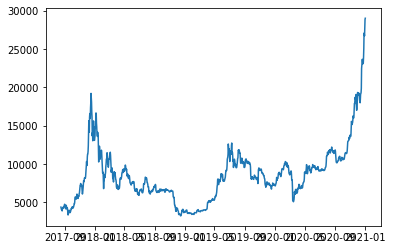

In [93]:
dataOpen = data[['Start','Open']]

dataOpen = dataOpen.set_index('Start')
dataOpen = dataOpen.resample('24H').mean() #Open mean price per day

date = dataOpen.index #list of dates

range_ = pd.RangeIndex(0, len(dataOpen)) 

dataOpen = dataOpen.set_index(range_) 
plt.plot(date, dataOpen) #non-stationary



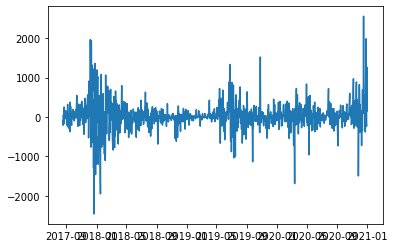

In [210]:
dataOpen_stat = dataOpen.diff(periods=1).dropna() #stationary
plt.plot(date[1:], dataOpen_stat)


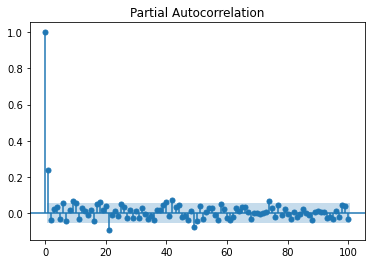

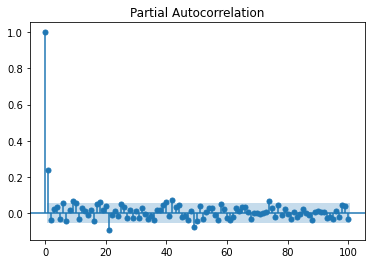

In [95]:
#AR
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(dataOpen_stat, lags=100)

/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


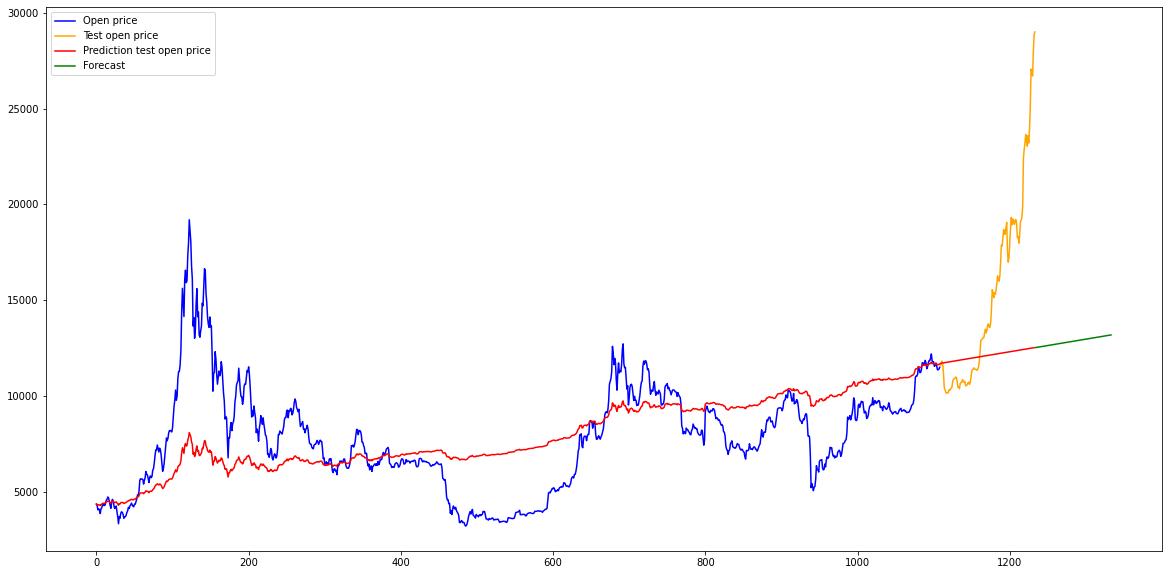

In [211]:
from statsmodels.tsa.ar_model import AutoReg

model_ar = AutoReg(dataOpen_stat[:int(len(dataOpen_stat)*0.9)], lags=1, old_names=True).fit()

yhat_ar = model_ar.predict(1, len(dataOpen_stat)+100) #predict stationary series

plt.figure(figsize=(20,10))

#predict non-stationary series
yhat_ar_renewed = np.zeros(len(yhat_ar))
yhat_ar_renewed [0] = dataOpen[0:1].values

for i in range(1,len(yhat_ar)):
    yhat_ar_renewed[i] = yhat_ar[i-1:i].values[0] +  yhat_ar_renewed[i-1]
    
plt.plot(dataOpen[:int(len(dataOpen_stat)*0.9)], 'b', label='Open price')
plt.plot(dataOpen[int(len(dataOpen_stat)*0.9):], 'orange', label='Test open price')
plt.plot(yhat_ar_renewed[:len(dataOpen_stat)], 'r', label= 'Prediction test open price')
plt.plot([i for i in range(1234,1334)], yhat_ar_renewed[len(dataOpen_stat):], 'g', label= 'Forecast')
plt.legend()

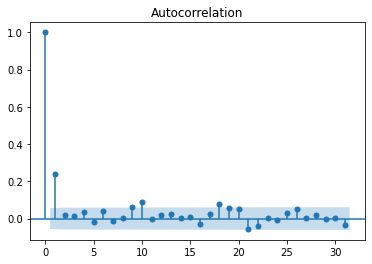

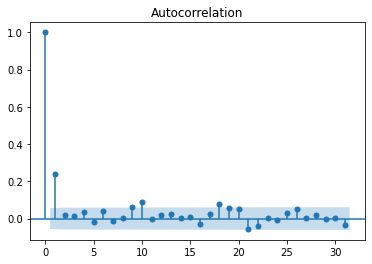

In [104]:
#MA

plot_acf(dataOpen_stat)

/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


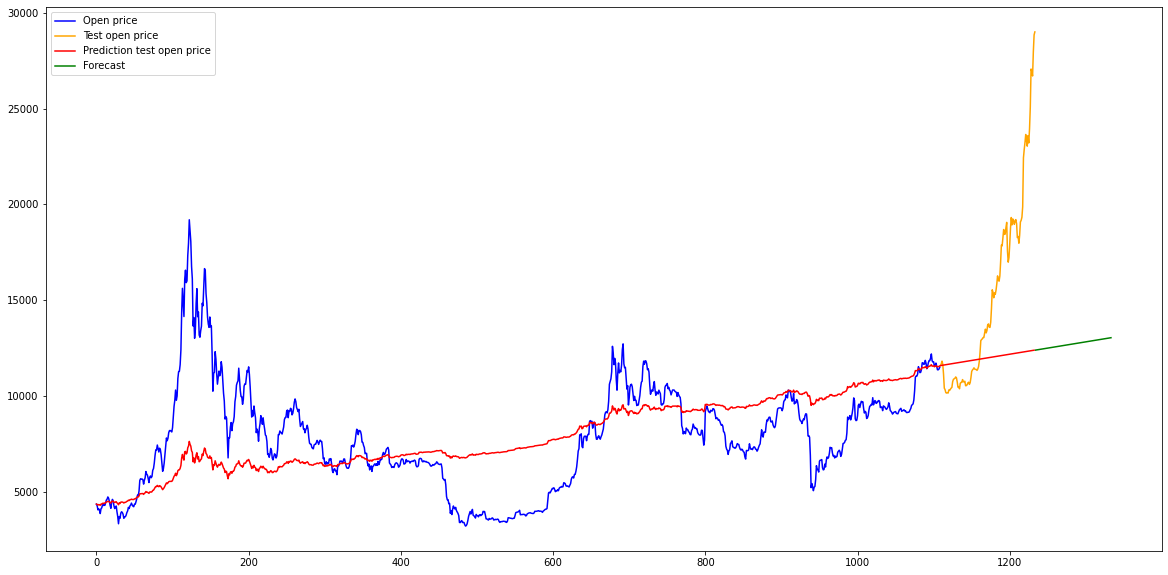

In [212]:
from statsmodels.tsa.arima.model import ARIMA

model_ma = ARIMA(dataOpen_stat[:int(len(dataOpen_stat)*0.9)], order=(0,0,1)).fit()
yhat_ma = model_ma.predict(1, len(dataOpen_stat)+100)

plt.figure(figsize=(20,10))

#predict non-stationary series
yhat_ma_renewed = np.zeros(len(yhat_ma))
yhat_ma_renewed[0] = dataOpen[0:1].values

for i in range(1,len(yhat_ma)):
    yhat_ma_renewed[i] = yhat_ma[i-1:i].values[0] +  yhat_ma_renewed[i-1]
    
plt.plot(dataOpen[:int(len(dataOpen_stat)*0.9)], 'b', label='Open price')
plt.plot(dataOpen[int(len(dataOpen_stat)*0.9):], 'orange', label='Test open price')
plt.plot(yhat_ma_renewed[:len(dataOpen_stat)], 'r', label= 'Prediction test open price')
plt.plot([i for i in range(1234, 1334)], yhat_ma_renewed[len(dataOpen_stat):], 'g', label= 'Forecast')
plt.legend()

/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


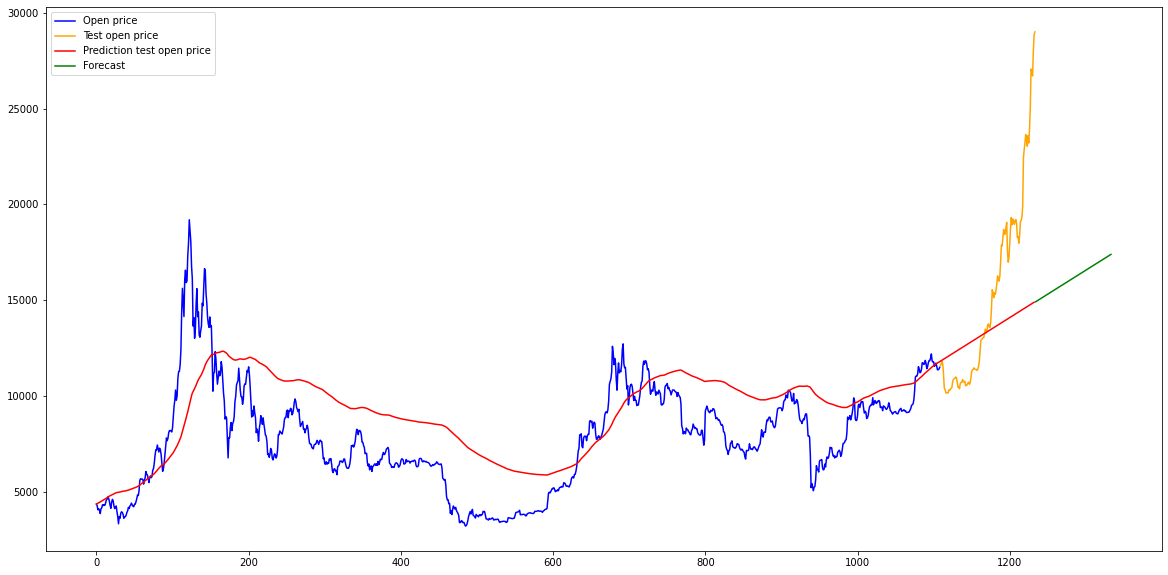

In [213]:
#SES
from statsmodels.tsa.api import SimpleExpSmoothing

model_ses = SimpleExpSmoothing(dataOpen_stat[:int(len(dataOpen_stat)*0.9)]).fit()
yhat_ses = model_ses.predict(1, len(dataOpen_stat)+100)

#predict non-stationary series
yhat_ses_renewed = np.zeros(len(yhat_ses))
yhat_ses_renewed [0] = dataOpen[0:1].values

for i in range(1,len(yhat_ses)):
    yhat_ses_renewed [i] = yhat_ses[i-1:i].values[0] +  yhat_ses_renewed [i-1]

plt.figure(figsize=(20,10))
plt.plot(dataOpen[:int(len(dataOpen_stat)*0.9)], 'b', label='Open price')
plt.plot(dataOpen[int(len(dataOpen_stat)*0.9):], 'orange', label='Test open price')
plt.plot(yhat_ses_renewed[:len(dataOpen_stat)], 'r', label= 'Prediction test open price')
plt.plot([i for i in range(1234, 1334)], yhat_ses_renewed[len(dataOpen_stat):], 'g', label= 'Forecast')
plt.legend()

/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/maksym/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


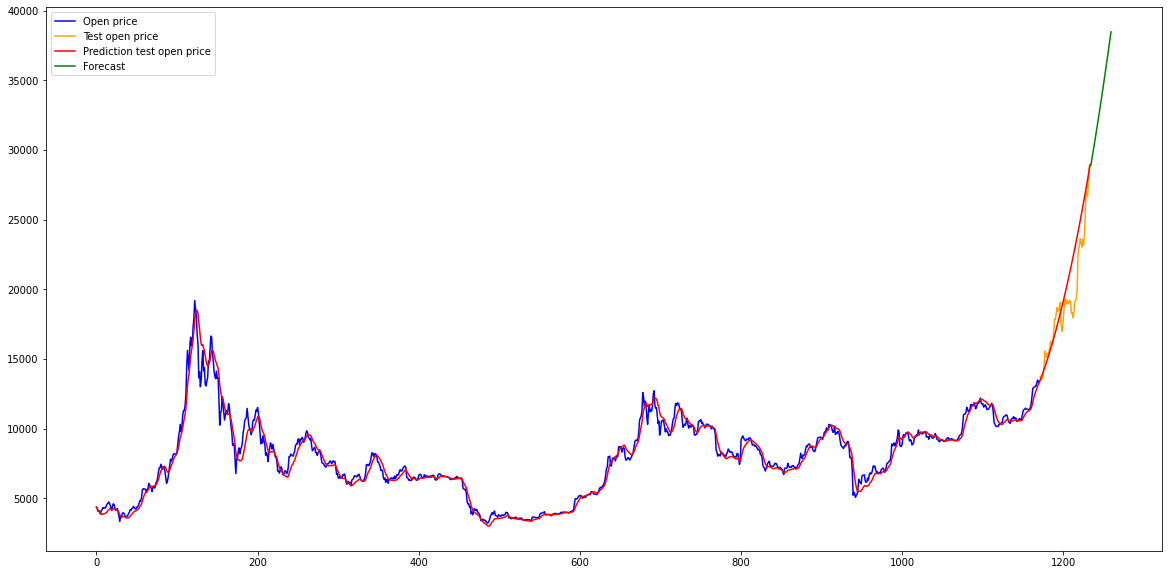

In [258]:
#HWES
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hwes = ExponentialSmoothing(dataOpen_stat[:int(len(dataOpen_stat)*0.95)], trend = 'add').fit()
yhat_hwes = model_hwes.predict(1, len(dataOpen)+25)

#predict non-stationary series
yhat_hwes_renewed  = np.zeros(len(yhat_hwes))
yhat_hwes_renewed[0] = dataOpen[0:1].values

for i in range(1,len(yhat_hwes)):
    yhat_hwes_renewed[i] = yhat_hwes[i-1:i].values[0] +  yhat_hwes_renewed[i-1]

plt.figure(figsize=(20,10))
plt.plot(dataOpen[:int(len(dataOpen_stat)*0.95)], 'b', label='Open price')
plt.plot(dataOpen[int(len(dataOpen_stat)*0.95):], 'orange', label='Test open price')
plt.plot(yhat_hwes_renewed[:len(dataOpen_stat)+1], 'r', label= 'Prediction test open price')
plt.plot([i for i in range(1234, 1260)], yhat_hwes_renewed[len(dataOpen_stat):], 'g', label= 'Forecast')
plt.legend()

In [261]:
from sklearn.metrics import mean_absolute_error

print('AR mean absolute error : ', mean_absolute_error(dataOpen, yhat_ar_renewed[:-99]))
print('MA mean absolute error : ',  mean_absolute_error(dataOpen, yhat_ma_renewed[:-99]))
print('SES mean absolute error : ', mean_absolute_error(dataOpen, yhat_ses_renewed[:-99]))
print('HWES mean absolute error : ', mean_absolute_error(dataOpen, yhat_hwes_renewed[:-25]))

AR mean absolute error :  2057.682849334643
MA mean absolute error :  2107.145854478513
SES mean absolute error :  2114.322728405819
HWES mean absolute error :  397.701536232963
